In [90]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns

# Reading and normalizing data

In [12]:
data = pd.read_csv("data/train.csv")
data = shuffle(data)
names = data["Name"]
ids = data["PassengerId"]
data = data.drop(["Name", "PassengerId"], axis = 1)
data["Sex"] = data["Sex"].map({"male": 1, "female": 0})
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})
data = data.drop(["Cabin", "Ticket"], axis = 1)
# data = data.fillna(-1)
data = data.dropna()

In [13]:
# data = pd.get_dummies(data)
data = shuffle(data)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
701,1,1,1,35.0,0,0,26.2875,0.0
553,1,3,1,22.0,0,0,7.2250,1.0
623,0,3,1,21.0,0,0,7.8542,0.0
541,0,3,0,9.0,4,2,31.2750,0.0
446,1,2,0,13.0,0,1,19.5000,0.0
...,...,...,...,...,...,...,...,...
583,0,1,1,36.0,0,0,40.1250,1.0
175,0,3,1,18.0,1,1,7.8542,0.0
272,1,2,0,41.0,0,1,19.5000,0.0
733,0,2,1,23.0,0,0,13.0000,0.0


### Few data

In [14]:
y = data["Survived"]
data = data.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 11)

# Logistic Regression

## Logistic Regression without scaling

In [19]:
logit = LogisticRegressionCV(Cs = [10, 1, 0.1, 0.01, 0.001], class_weight = "balanced", \
                             solver = "lbfgs", random_state = 11, verbose = True, n_jobs = -1)

In [20]:
cross_val_score(logit, X_train, y_train, cv = 7)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   

array([0.81707317, 0.7804878 , 0.81481481, 0.79012346, 0.80246914,
       0.81481481, 0.7654321 ])

In [21]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


LogisticRegressionCV(Cs=[10, 1, 0.1, 0.01, 0.001], class_weight='balanced',
                     cv=None, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=11, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=True)

In [22]:
logit.C_

array([0.1])

In [25]:
accuracy_score(logit.predict(X_train), y_train)

0.7943760984182777

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(logit.predict(X_test), y_test)

0.7902097902097902

### Let's have a look at the feature importane

In [33]:
pd.DataFrame({"feature": X_train.columns,
             "coef": 
              logit.coef_.flatten()}).sort_values(by = "coef", ascending = False)

,feature,coef
6,Embarked,0.226681
4,Parch,0.041189
5,Fare,0.005615
2,Age,-0.033739
3,SibSp,-0.321882
0,Pclass,-0.928967
1,Sex,-1.599680


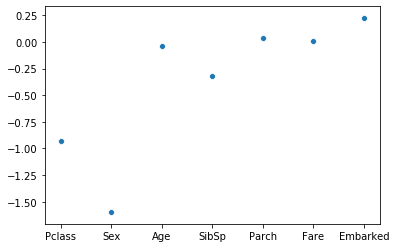

In [34]:
sns.scatterplot(X_train.columns, logit.coef_.flatten());

## Logistic Regression with scaling

In [35]:
from sklearn.linear_model import LogisticRegressionCV
logit_scaled = LogisticRegressionCV(Cs = [1, 0.1, 0.01, 0.001], class_weight = "balanced", solver = "lbfgs", random_state = 11, verbose = True, n_jobs = -1)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
cross_val_score(logit_scaled, X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

array([0.78070175, 0.74561404, 0.77192982, 0.80701754, 0.78761062])

In [37]:
logit_scaled.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


LogisticRegressionCV(Cs=[1, 0.1, 0.01, 0.001], class_weight='balanced', cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=11, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=True)

In [38]:
accuracy_score(logit_scaled.predict(X_train_scaled), y_train)

0.7908611599297012

In [39]:
accuracy_score(logit_scaled.predict(X_test_scaled), y_test)

0.7832167832167832

### Let's have a look at the feature importane

In [40]:
pd.DataFrame({"feature": X_train.columns,
             "coef": logit_scaled.coef_.flatten()}).sort_values(by = "coef", ascending = False)

,feature,coef
5,Fare,0.146577
6,Embarked,0.145396
4,Parch,-0.000160
3,SibSp,-0.404904
2,Age,-0.583828
0,Pclass,-1.033419
1,Sex,-1.174997


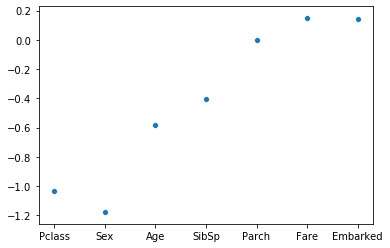

In [41]:
sns.scatterplot(X_train.columns, logit_scaled.coef_.flatten());

# Random Forest

In [61]:
rf = RandomForestClassifier(n_estimators = 71, random_state = 11, verbose = True)

In [62]:
params = {
    "max_depth": np.arange(5, 12),
#     "min_samples_split": np.arange(5, 12),
    "oob_score": [True, False]
}
best_rf = GridSearchCV(rf, params, n_jobs = -1, verbose = 2)

In [63]:
cross_val_score(best_rf, X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished


array([0.8245614 , 0.79824561, 0.80701754, 0.83333333, 0.82300885])

In [64]:
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=71, n_jobs=None,
                                              oob_score=False, random_state=11,
                                

In [65]:
best_rf.best_params_

{'max_depth': 8, 'oob_score': True}

In [66]:
accuracy_score(best_rf.predict(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished


0.9332161687170475

In [67]:
accuracy_score(best_rf.predict(X_test), y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished


0.8041958041958042

### Let's have a look at the feature importane

In [68]:
importance = pd.DataFrame({"col": X_train.columns,
             "coef": best_rf.best_estimator_.feature_importances_}).sort_values(by = "coef", ascending = False);

In [69]:
importance

,col,coef
1,Sex,0.274883
5,Fare,0.249039
2,Age,0.203045
0,Pclass,0.138182
4,Parch,0.050162
3,SibSp,0.048652
6,Embarked,0.036036


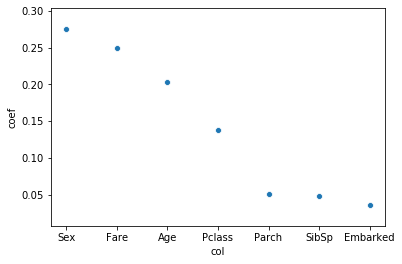

In [70]:
sns.scatterplot(importance["col"], importance["coef"]);

## As I mentioned in the Analysis, Sex, Fare and Age are very important features

# Finally, Logistic Regression is the best model of classification this data (TSNE gave a hint). Scaling is needed.

###############################################################

# XGBClassifier

In [88]:
import xgboost as xgb
# bst = xgb.XGBClassifier(max_depth = 9, learning_rate = 1e-3, booster = "gbtree", n_jobs = -1)
bst = xgb.XGBClassifier(n_jobs = -1, silent = False, n_estimators = 301)
params = {
    "reg_alpha": [0.1, 0.2, 0.3, 0.4],
    "scale_pos_weight": [1, 0.5, 0.1],
    "max_depth": np.arange(2, 6),
    "learning_rate": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "booster": ["gbtree", "gblinear", "dart"]
}

bst = GridSearchCV(bst, params, n_jobs = -1, verbose = 5)

In [89]:
cross_val_score(bst, X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.7min finished


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.8min finished


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | el

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.7min finished


array([0.81578947, 0.8245614 , 0.80701754, 0.76315789, 0.82300885])

In [91]:
bst.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  3.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],


In [92]:
bst.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.01,
 'max_depth': 5,
 'reg_alpha': 0.1,
 'scale_pos_weight': 1}

In [93]:
accuracy_score(bst.predict(X_train), y_train)

0.8857644991212654

In [94]:
accuracy_score(bst.predict(X_test), y_test)

0.8251748251748252

## Writing boosting and Random Forest to files

In [98]:
import pickle
models = {
    "rf.sav": best_rf,
    "xgb.sav": bst
}
for model in models:
    pickle.dump(models[model], open(model, "wb"))